# Month to Month Graph of Most Dangerous Streets

Make a chart over time to show how the most dangerous streets have changed over time. 

In [1]:
import pytz
import folium
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib._color_data import BASE_COLORS, TABLEAU_COLORS, CSS4_COLORS, XKCD_COLORS

from crash_data_analysis import CrashDataAnalysis

In [2]:
cda = CrashDataAnalysis()

In [3]:
query = """
with route_centerline_count as (
    select
    sr.gid
    , sr.lrsroute
    , sc.fullname
    , st_AsGeoJSON(sr.geom) as street_line
    , row_number() over (partition by sr.gid, sr.lrsroute order by count(distinct sc.masterid) desc) 
        as fullname_priority

    from street_routes sr
    inner join street_centerline sc using (lrsroute)

    group by 1,2,3,4
)

, crashes_routes as (
    select distinct
    case 
        when sr.gid = 3901 then 3900 
        when sr.gid = 1453 then 1452
        else sr.gid end as gid
    , c.incident_id
    , to_char(c.reported_date, 'YYYY-MM') as crash_year_month
    , c.sbi
    , c.fatality
    , c.sbi_or_fatality

    from street_routes sr
    inner join crashes c on st_dwithin(sr.geom_denver, c.geom_denver, 25)

    where not at_freeway
    
    -- Exclude this month's crashes
    and to_char(c.reported_date, 'YYYY-MM') < to_char(current_timestamp, 'YYYY-MM')
    
    -- Start on July 1, 2020
    -- and to_char(c.reported_date, 'YYYY-MM') >= '2020-07'
    
    -- Exclude the first pandemic months
    -- and to_char(c.reported_date, 'YYYY-MM') not in ('2020-04', '2020-05', '2020-06')
)

, count_routes as (
    select
    cr.gid
    , sr1.lrsroute
    , st_length(sr1.geom_denver) / 5280 as length_miles
    , cr.crash_year_month
    , count(cr.incident_id) as num_crashes
    , sum(cr.sbi::int) as num_sbi
    , sum(cr.fatality::int) as num_fatality
    , sum(cr.sbi_or_fatality::int) as num_sbi_or_fatality
    
    from crashes_routes cr
    inner join street_routes sr1 using (gid)
    
    group by 1,2,3,4
)

select
count_routes.gid
, rcc.fullname
, rcc.street_line
, count_routes.length_miles
, count_routes.crash_year_month
, count_routes.num_crashes
, count_routes.num_sbi
, count_routes.num_fatality
, count_routes.num_sbi_or_fatality

from count_routes
inner join route_centerline_count rcc on (rcc.gid = count_routes.gid and rcc.fullname_priority = 1)

order by count_routes.gid, count_routes.crash_year_month
"""

In [4]:
# street_month_crashes = pd.read_sql(query, cda.conn)
# street_month_crashes.to_csv('data/street_month_crashes.csv', index=False)

In [5]:
street_month_crashes = pd.read_csv('data/street_month_crashes.csv')

In [6]:
# Fill in the data gaps so there is one row per street and month

all_months = pd.DataFrame(
    pd.date_range(start=datetime(2013,1,1), end=datetime(2023,4,1), freq='M').strftime('%Y-%m')
    , columns=['crash_year_month']
)

all_streets = street_month_crashes[['gid', 'fullname', 'street_line', 'length_miles']].drop_duplicates()

all_months_streets = pd.merge(all_months, all_streets, how='cross')

street_month_crashes_all_months = pd.merge(
    all_months_streets
    , street_month_crashes
    , how='left'
    , on=['crash_year_month', 'gid', 'fullname', 'street_line', 'length_miles']
).fillna(0)

In [7]:
median_month_crashes = street_month_crashes_all_months.groupby(
    ['gid', 'fullname']).num_crashes.median().reset_index(name='median_num_crashes')

In [8]:
highest_median_crashes = median_month_crashes.sort_values(by='median_num_crashes', ascending=False).head(30)
highest_median_crashes

,gid,fullname,median_num_crashes
686,1012,E COLFAX AVE,34.0
690,1016,N COLORADO BLVD,32.0
4220,7584,S FEDERAL BLVD,31.0
2712,4689,N FEDERAL BLVD,27.0
2135,3900,N SPEER BLVD,26.0
591,880,N BROADWAY,23.0
3798,6796,W ALAMEDA AVE,21.0
2635,4592,S COLORADO BLVD,20.0
1544,2474,N QUEBEC ST,20.0
3136,5379,W COLFAX AVE,18.0


In [9]:
list_of_street_gids_to_plot = list(highest_median_crashes['gid'])

## All crashes in Denver by month

When did crash rate stabilize after the pandemic begun? Approx July 1, 2020

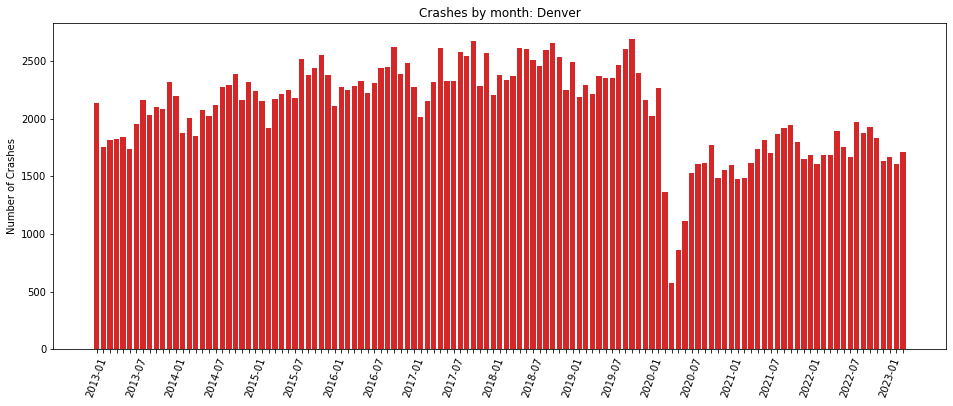

In [10]:
denver_crashes_by_month = street_month_crashes.groupby('crash_year_month').num_crashes.sum()

fig, ax = plt.subplots(figsize=(16,6))

ax.bar(
    x=denver_crashes_by_month.index
    , height=denver_crashes_by_month
    , color=TABLEAU_COLORS['tab:red']
)

ax.tick_params(axis='x', rotation=70)

n = 6  # Keep every Nth label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

plt.ylabel('Number of Crashes')
_ = plt.title(f'Crashes by month: Denver')
# plt.savefig('images/denver_crashes_by_month.png', transparent=False, facecolor='white', bbox_inches='tight')
# denver_crashes_by_month.to_clipboard()

In [11]:
# Calculate how many of the city's crashes take place on each street within each month

street_month_crashes_citywide_in_month = pd.merge(
    street_month_crashes_all_months
    , denver_crashes_by_month.reset_index()
    , how='inner'
    , on='crash_year_month'
    , suffixes=['', '_citywide_in_month']
)

street_month_crashes_citywide_in_month['share_of_city_crashes'] = (
    street_month_crashes_citywide_in_month.num_crashes 
    / street_month_crashes_citywide_in_month.num_crashes_citywide_in_month
)

In [12]:
# Calculate the median share of the city's crashes take place on each street across months

street_month_crashes_median_all_time = pd.merge(
    street_month_crashes_citywide_in_month
    , street_month_crashes_citywide_in_month.groupby('gid').share_of_city_crashes.median().reset_index()
    , how='inner'
    , on='gid'
    , suffixes=['', '_median_all_time']
)

In [13]:
# # Exclude streets with a small number of crashes (but how?)
# (street_month_crashes_median_all_time.share_of_city_crashes_median_all_time > 100 
# / street_month_crashes_median_all_time.num_crashes.sum()).sum()

# len(street_month_crashes_median_all_time)

In [14]:
street_month_crashes_median_all_time['expected_crashes'] = (
    street_month_crashes_median_all_time.share_of_city_crashes_median_all_time
    * street_month_crashes_median_all_time.num_crashes_citywide_in_month
)

In [15]:
street_month_crashes_median_all_time['diff_expected_crashes'] = (
    street_month_crashes_median_all_time.num_crashes - street_month_crashes_median_all_time.expected_crashes
)

In [16]:
street_month_crashes_median_all_time.sort_values(by='diff_expected_crashes')

,crash_year_month,gid,fullname,street_line,length_miles,num_crashes,num_sbi,num_fatality,num_sbi_or_fatality,num_crashes_citywide_in_month,share_of_city_crashes,share_of_city_crashes_median_all_time,expected_crashes,diff_expected_crashes
519142,2019-11,7584,S FEDERAL BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",4.373528,11.0,0.0,0.0,0.0,2393,0.004597,0.014274,34.157830,-23.157830
519131,2018-12,7584,S FEDERAL BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",4.373528,15.0,1.0,0.0,1.0,2252,0.006661,0.014274,32.145188,-17.145188
84389,2013-12,1012,E COLFAX AVE,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.475202,21.0,0.0,0.0,0.0,2317,0.009063,0.016421,38.047579,-17.047579
84978,2022-01,1016,N COLORADO BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.184503,9.0,0.0,0.0,0.0,1687,0.005335,0.014799,24.966173,-15.966173
84943,2019-02,1016,N COLORADO BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.184503,17.0,1.0,0.0,1.0,2184,0.007784,0.014799,32.321353,-15.321353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84417,2016-04,1012,E COLFAX AVE,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.475202,55.0,1.0,0.0,1.0,2283,0.024091,0.016421,37.489263,17.510737
333619,2016-08,4689,N FEDERAL BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.367276,49.0,4.0,0.0,4.0,2442,0.020066,0.012528,30.593289,18.406711
333605,2015-06,4689,N FEDERAL BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.367276,47.0,0.0,0.0,0.0,2246,0.020926,0.012528,28.137808,18.862192
189934,2014-11,2474,N QUEBEC ST,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.785164,41.0,3.0,0.0,3.0,2163,0.018955,0.009231,19.966154,21.033846


In [17]:
# last_month = street_month_crashes_median_all_time[
#     street_month_crashes_median_all_time.crash_year_month == '2023-03']

# this_map = folium.Map(prefer_canvas=True, tiles='Stamen Toner')

# good_streets = last_month.sort_values(by='diff_expected_crashes').head(5)['street_line']
# bad_streets = last_month.sort_values(by='diff_expected_crashes').tail(5)['street_line']

# for good_street in good_streets:
#     folium.GeoJson(good_street, style_function=lambda x: {'color': 'green'}).add_to(this_map)

# for bad_street in bad_streets:
#     folium.GeoJson(bad_street, style_function=lambda x: {'color': 'red'}).add_to(this_map)
    
# this_map.fit_bounds(this_map.get_bounds())
# this_map

In [18]:
# last_month.sort_values(by='diff_expected_crashes')

In [19]:
street_month_crashes_median_all_time = street_month_crashes_median_all_time.sort_values(by='crash_year_month')

In [20]:
def plot_one_street(street_gid_to_plot):
    fig, ax = plt.subplots(figsize=(16,6))

    data_to_plot = street_month_crashes_median_all_time.loc[
        street_month_crashes_median_all_time.gid == street_gid_to_plot
        , ['gid', 'fullname', 'crash_year_month', 'diff_expected_crashes']
    ].copy()

    this_street_name = data_to_plot['fullname'].values[0].title()
    this_street_filename = this_street_name.replace(' ','_')

    data_to_plot['color'] = data_to_plot.diff_expected_crashes.apply(
        lambda x: TABLEAU_COLORS['tab:green'] if x < 0 else TABLEAU_COLORS['tab:red']
    )

    ax.bar(
        x=data_to_plot['crash_year_month']
        , height=data_to_plot['diff_expected_crashes']
        , color=data_to_plot['color']
    )

    ax.tick_params(axis='x', rotation=70)

    n = 6  # Keep every Nth label
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

    plt.ylabel('Number of Crashes')
    _ = plt.title(f'Crashes by month: {this_street_name} (gid: {street_gid_to_plot})')

    plt.savefig(
        f'images/streets/crashes_by_month_{this_street_filename}_{street_gid_to_plot}.png'
        , transparent=False, facecolor='white', bbox_inches='tight'
    )
    plt.close()

In [21]:
for gid in list_of_street_gids_to_plot:
    plot_one_street(gid)